<a href="https://colab.research.google.com/github/chaiai/deep-learning/blob/main/cat_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install TensorFlow's object detection model in Colab

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models/

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624934 sha256=b05cff5950f069c3472b992bbb7d4e263c4bcae211cf3bef2793e9f5ecd44368
  Stored in directory: /tmp/pip-ephem-wheel-cache-2n6s73yr/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


# Imports

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils  import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

# import module for utilities in Colab
from object_detection.utils import colab_utils

# Utility functions

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

# Visualize cat images

/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/cabbie.jpg
/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/cedric.jpg
/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/chai.jpg
/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/cheddar.jpg
/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/pigeon.jpg


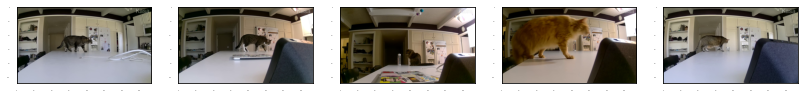

In [ ]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = '/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-pics/'

# create a list of cats to loop through
cats = ['cabbie', 'cedric', 'chai', 'cheddar', 'pigeon']

# declare an empty list
train_images_np = []

# run a for loop for each image
for cat in cats: # @REPLACE for i in range(None, None)

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir + str(cat) + ".jpg")
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

# Prepare data for training

In [ ]:
# Define the list of ground truth boxes
gt_boxes = []

In [ ]:
# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [ ]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.36944444 0.2921875  0.59777778 0.559375  ]]
[[0.34944444 0.42395833 0.58611111 0.69635417]]
[[0.53944444 0.484375   0.77777778 0.70052083]]
[[0.09944444 0.07239583 0.68777778 0.64895833]]
[[0.36777778 0.23229167 0.59111111 0.49322917]]


In [ ]:
cabbie_id = 1
cedric_id = 2
chai_id = 3
cheddar_id = 4
pigeon_id = 5

category_index = {
    cabbie_id: {
        'id': cabbie_id,
        'name': 'cabbie'
    },
    cedric_id: {
        'id': cedric_id,
        'name': 'cedric'
    },
    chai_id: {
        'id': chai_id,
        'name': 'chai'
    },
    cheddar_id: {
        'id': cheddar_id,
        'name': 'cheddar'
    },
    pigeon_id: {
        'id': pigeon_id,
        'name': 'pigeon'
    }
}

# Specifiy the number of classes being predicted
num_classes = 5

In [ ]:
print(category_index[chai_id])

{'id': 3, 'name': 'chai'}


# Data preprocessing

In [ ]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


# Vizualize cats and their ground truth bounding boxes

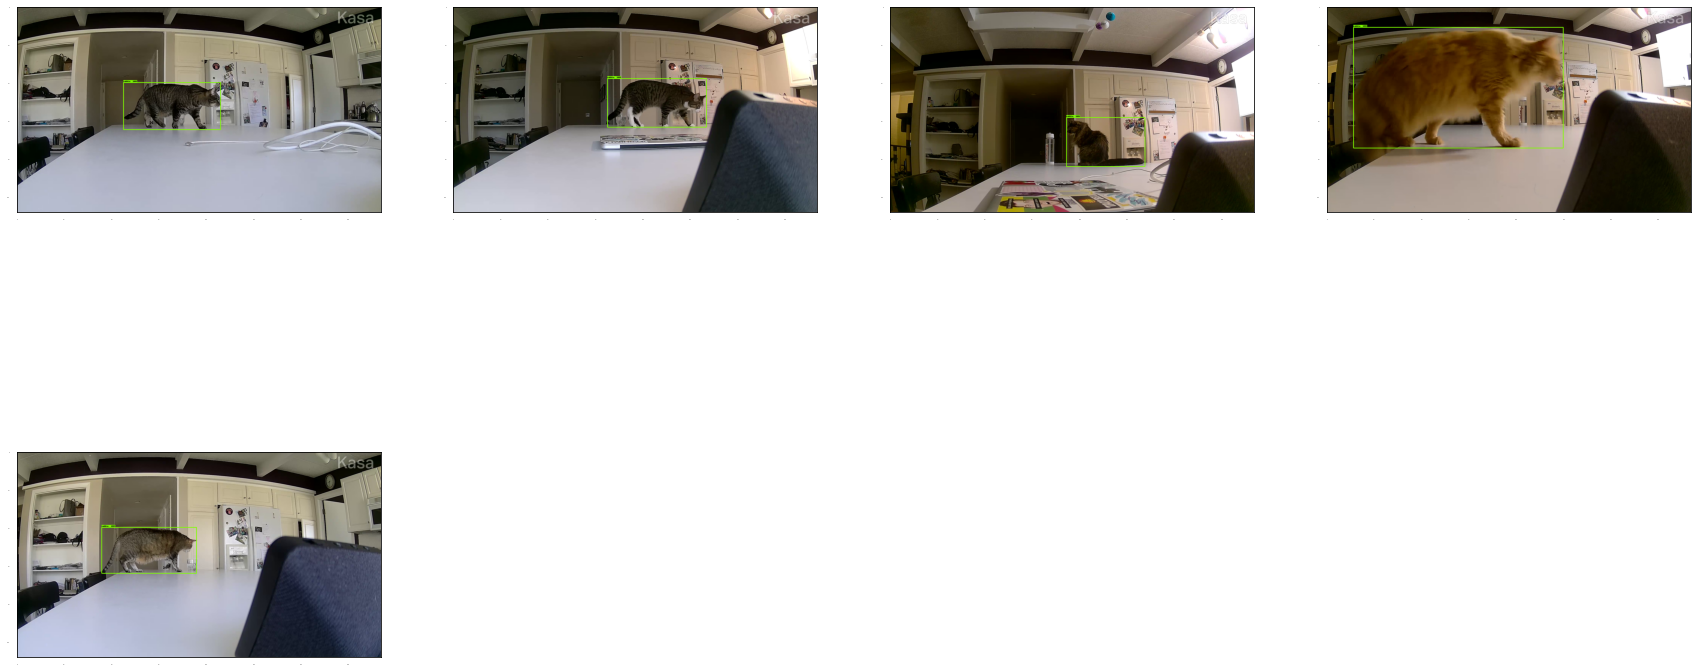

In [ ]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

# Download the checkpoint containing the pre-trained RetinaNet weights

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz

!tar -xf ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz

# Copy the checkpoint to the TensorFlow model test folder
!mv ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-03-11 20:24:41--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244755628 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.42M  92.1MB/s    in 2.5s    

2021-03-11 20:24:43 (92.1 MB/s) - ‘ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz’ saved [244755628/244755628]



# Configure the model

In [ ]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
configs

In [ ]:
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs["model"]

# see what model_config looks like
model_config

## Modify model_config

In [ ]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after you've customized it!
model_config

# Build the custom model

In [ ]:
detection_model = model_builder.build(
    model_config, is_training=True)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


# Restore weights from the loaded checkpoint

In [ ]:
# Run this to check the type of detection_model
detection_model

In [ ]:
vars(detection_model)

## Define Checkpoints for the box predictor

In [ ]:
# view the type of _box_predictor
detection_model._box_predictor

In [ ]:
vars(detection_model._box_predictor)

In [ ]:
tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

In [ ]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)

tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_attached_dependencies': None,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f65c01587d0>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f65c0108550>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_base_tower_layers_for_heads', ref=DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])})),
  TrackableReference(name='_box_prediction_head', ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7f65c01587d0>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_depe

## Define the temporary model Checkpoint

In [ ]:
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)

In [ ]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)

tensorflow.python.training.tracking.util.Checkpoint

In [ ]:
vars(tmp_model_checkpoint)

{'_attached_dependencies': None,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f65cc2eae10>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='model', ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7f65cc2ea5d0>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'model': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f65cc2ea5d0>},
 '_self_update_uid': -1,
 'model': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f65cc2ea5d0>}

## Restore the Checkpoints to the model

In [ ]:
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint) 

# Restore the checkpoint to the checkpoint path
tmp_model_checkpoint.restore(checkpoint_path).expect_partial()

# Run a dummy image to generate the model variables

In [ ]:
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

print('Weights restored!')

Weights restored!


In [ ]:
# Test Code:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


In [ ]:
tf.keras.backend.set_learning_phase(True)

# set the batch_size
batch_size = 4

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
# Inspect the layers of detection_model
for i, v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

In [ ]:
# define a list that contains the layers that you wish to fine tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [ ]:
# Test Code:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


In [ ]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:batch_size]

In [ ]:
# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 1024, 1024, 3)
index 1 has information about the image's true shape excluding padding: [[1024 1024    3]]


In [ ]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 4

true_shape_list is of type <class 'list'>
true_shape_list has length 4


In [ ]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: 'list' object has no attribute 'get_shape'


In [ ]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (4, 1024, 1024, 3)
true_shape_tensor shape: (4, 3)


In [ ]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [ ]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [ ]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:batch_size]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:batch_size]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [ ]:
# Calculate the loss after you've provided the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.05717160
classification loss 1.13530493


In [ ]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

# All together as a @tf.function

In [ ]:
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:

        # Preprocess the images
        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0) 
        true_shape_tensor = preprocessed_image_tensor.shape 

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
    return total_loss

In [ ]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.216715
batch 10 of 100, loss=0.4115076
batch 20 of 100, loss=0.063771814
batch 30 of 100, loss=0.11230838
batch 40 of 100, loss=0.0068986733
batch 50 of 100, loss=0.002221873
batch 60 of 100, loss=0.002791498
batch 70 of 100, loss=0.0017319113
batch 80 of 100, loss=0.0011121639
batch 90 of 100, loss=0.0013512612
Done fine-tuning!


In [ ]:
!rm -rf ./results

In [ ]:
# unzip test images
local_zip = '/content/drive/MyDrive/Colab Notebooks/computer-vision/cat-vids/testframes.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/results')
zip_ref.close()

In [ ]:
test_image_dir = '/content/results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(1, 101):
    image_path = os.path.join(test_image_dir, 'ezgif-frame-' + "{0:03}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

/content/results/ezgif-frame-001.jpg
/content/results/ezgif-frame-002.jpg
/content/results/ezgif-frame-003.jpg
/content/results/ezgif-frame-004.jpg
/content/results/ezgif-frame-005.jpg
/content/results/ezgif-frame-006.jpg
/content/results/ezgif-frame-007.jpg
/content/results/ezgif-frame-008.jpg
/content/results/ezgif-frame-009.jpg
/content/results/ezgif-frame-010.jpg
/content/results/ezgif-frame-011.jpg
/content/results/ezgif-frame-012.jpg
/content/results/ezgif-frame-013.jpg
/content/results/ezgif-frame-014.jpg
/content/results/ezgif-frame-015.jpg
/content/results/ezgif-frame-016.jpg
/content/results/ezgif-frame-017.jpg
/content/results/ezgif-frame-018.jpg
/content/results/ezgif-frame-019.jpg
/content/results/ezgif-frame-020.jpg
/content/results/ezgif-frame-021.jpg
/content/results/ezgif-frame-022.jpg
/content/results/ezgif-frame-023.jpg
/content/results/ezgif-frame-024.jpg
/content/results/ezgif-frame-025.jpg
/content/results/ezgif-frame-026.jpg
/content/results/ezgif-frame-027.jpg
/

In [ ]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [ ]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [ ]:
x = np.array(results['scores'])

# percent of frames where a cat is detected
cat_detected = (np.where(x > 0.9, 1, 0).sum())/100*100
print(cat_detected)

50.0


In [ ]:
zipf = zipfile.ZipFile('./test.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

In [ ]:
#imageio.plugins.freeimage.download()

anim_file = '/test26.gif'

filenames = glob.glob('/content/results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimwrite(anim_file, images)

In [ ]:
import pickle

# write results to binary file. upload for grading.
with open('results.data', 'wb') as filehandle:
    pickle.dump(results['boxes'], filehandle)
